# Classifying images using Convolutional Neural Networks

In the first notebook about image classification, we used handcrafted features, HOG and SIFT, to classify images with a `LinearSVC` model. The performance was not bad, but we can do better. In this notebook, we will use deep learning models to classify the images in the Cats and Dogs dataset. Specifically, we will use Convolutional Neural Networks (CNN) to classify images. CNNs are a type of deep learning model that is well suited for image recognition problems. Instead of manually creating convolutional kernels like we did in the previous notebook, the power of convolutional neural networks comes from the fact that these kernels are *learned from the data*. We will now show how this works, but first we need to start again by loading the dataset and preparing the data for training.

In [93]:
!pip install datasets 

1660.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [94]:
import torch

def get_device():
    if torch.cuda.is_available(): 
        return torch.device('cuda') 
    if torch.backends.mps.is_available(): 
        return torch.device('mps')
    return torch.device('cpu')
device = get_device()

In [95]:
from datasets import load_dataset

dataset = load_dataset("cats_vs_dogs", split="train")

## Create a sample of images

The cats and dogs dataset is quite large. If we would use the entire dataset, the processing time would be too long. Therefore, we will create a sample of the dataset. We will also use the images that have a width of at least 300 pixels. From this selection, we create a sample of 500 images.

In [96]:
from itertools import islice
import numpy as np

def memory_efficient_sampler(dataset, sample_size, width_threshold=300, batch_size=100):
    """
    Yields indices of selected wide images in memory-efficient batches
    """
    selected = 0
    
    # Create shuffled indices
    all_indices = np.random.permutation(len(dataset))
    print("all indices", all_indices)
    
    # Process dataset in batches
    for i in range(0, len(all_indices), batch_size):
        batch_indices = all_indices[i:min(i + batch_size, len(all_indices))]
        batch = dataset.select(batch_indices)
        
        # Find wide images in current batch
        selected_batch_indices = [idx for idx, img in enumerate(batch['image']) 
                        if img.size[0] > width_threshold ]
        wide_indices = [batch_indices[idx] for idx in selected_batch_indices]

        # Randomly select from current batch
        batch_selection = np.random.choice(
            wide_indices, 
            size=min(len(wide_indices), sample_size - selected),
            replace=False
        ).tolist()
        
        # Update tracking
        selected += len(batch_selection)
        
        # Yield selected indices
        yield from batch_selection
        
        if selected >= sample_size:
            break


In [97]:
selected_indices = list(memory_efficient_sampler(dataset, sample_size=700))
dataset = dataset.select(selected_indices)

X = dataset['image']
y_true = dataset['labels']

all indices [15325 16023 20369 ...  7188 18281 13428]


In [98]:
import pandas as pd
pd.Series(y_true).value_counts()

0    379
1    321
Name: count, dtype: int64

## Split the data into a training and test set

We again split the data into a training and test set. We will use the training set to train the model and the test set to evaluate the model. We will use 80% of the data for training and 20% of the data for testing. We will use the `train_test_split` function from the `sklearn` library to split the data.

In [99]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

In [100]:
len(X_train), len(X_val), len(X_test)

(504, 56, 140)

## Some image examples

Before we extract the features and train a machine learning algorithm, let's first take a look at some examples of the images in the dataset. Every time you run the cell below, a random image of our sample will be shown.

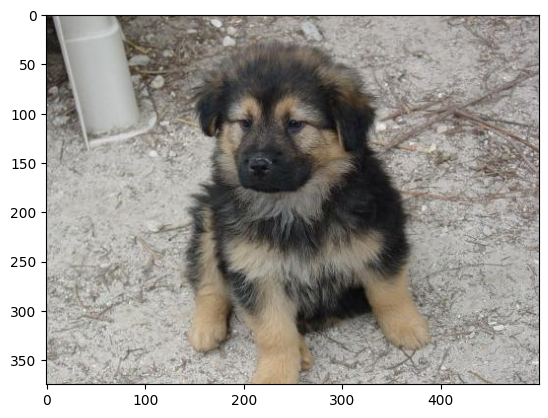

In [101]:
import matplotlib.pyplot as plt
import random

image = X_train[random.randint(0, len(X_train)-1)]
plt.imshow(image)

In [102]:
import torch
from torch.utils.data import Dataset

# Custom Dataset class
class CatsDogsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        else:
            image = np.array(image)
            image = torch.tensor(image)       
        
        return image, torch.tensor(label, dtype=torch.float32)


## Preprocessing



In [103]:
from torchvision import transforms

transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x if x.shape[0] >= 3 else x.repeat(3, 1, 1))
])

 To create the convolutional neural network, we are again using a **Sequential** model. The last hidden layers are the same as the ones that were used in fully connected model above. However, we see that the first hidden layer has been replaced by several other layers: Conv2D and MaxPooling2D layers. A Conv2D layer has three parameters. It has a *width*, a *height*, and a *depth*. The *width* and *height* give the dimension of the two dimensional convolutional kernel, in the first Conv2D layer this dimension is 5 x 5. The *depth* gives the number of convolutional kernels that can be learned in this layer of the network. The result of this layer is a 3D volume of activations. To convert this 3D volume back to an input that is suitable for a **Dense** layer, we need an extra layer in the network: the **Flatten** layer. In addition, we see the use of a **MaxPooling2D** layer, a special layer that "summarizes" the output of a **Conv2D** layer.

In [104]:
import torch.nn as nn
import tqdm

class CatsDogsCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            # First Conv Block
            # Input size: 300 x 300 x 3
            
            nn.Conv2d(3, 16, kernel_size=5, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # https://stackoverflow.com/questions/54423078/how-are-the-output-size-of-maxpooling2d-conv2d-upsampling2d-layers-calculated
            # Wnew = (W - F + 2*P)/S + 1 = (300 - 3 + 2*0)/2 + 1 = 149
            # Hnew = (H - F + 2*P)/S + 1 = (300 - 3 + 2*0)/2 + 1 = 149
            # Output size: 149 x 149 x 32
            
            # Second Conv Block
            nn.Conv2d(16, 16, kernel_size=5, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Output size: 74 x 74 x 32 = 17408

            # Third Conv Block
            nn.Conv2d(16, 16, kernel_size=5, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #output size: 36 x 36 x 32 = 41472

            # Fourth Conv Block
            nn.Conv2d(16, 16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Output size: 17 x 17 x 32 = 9248
           
            # Fourth Conv Block
            nn.Conv2d(16, 16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Output size: 8 x 8 x 16 = 1024
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def predict(self, dataloader, device='cpu', show_progress=True):
        # Set model to evaluation mode
        self.eval()
        self.to(device)
    
        all_predictions = []
    
        # Disable gradients
        with torch.no_grad():
            # Setup progress bar if requested
            iterator = tqdm.tqdm(dataloader) if show_progress else dataloader
        
            for batch in iterator:
                # Handle different batch types
                if isinstance(batch, (tuple, list)):
                    x = batch[0]
                else:
                    x = batch
                
                # Move batch to device
                x = x.to(device)
            
                # Get predictions
                outputs = self(x)
            
                # Convert to predictions based on task
                if outputs.shape[-1] > 1:  # Multi-class
                    predictions = outputs.argmax(dim=-1)
                else:  # Binary or regression
                    predictions = (outputs > 0.5).float()
            
                # Move to CPU and collect
                all_predictions.append(predictions.cpu())
    
    # Concatenate all batches
        return torch.cat(all_predictions).numpy()


Like in the previous example, we again compile the method with a **binary_crossentropy** loss function and again we observe the **accuracy**.

In [105]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20, device='cuda'):
    model = model.to(device)
    all_loss = []
    all_vall_loss = []       
    all_acc = []
    all_val_acc = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
       
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        print(f'Epoch {epoch+1}:')
        print(f'Training - Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
        print(f'Validation - Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*val_correct/val_total:.2f}%')
        all_loss.append(running_loss/len(train_loader))
        all_vall_loss.append(val_loss/len(test_loader))
        all_acc.append(100*correct/total)
        all_val_acc.append(100*val_correct/val_total)

    return np.array(all_loss), np.array(all_vall_loss), np.array(all_acc), np.array(all_val_acc)

Training the convolutional network is also equivalent to training the fully connected network above. The only difference is the format of the training set. Instead of vectors with size 16875, we now offer the images with a dimension of 75x75x3.

In [106]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Create datasets
train_dataset = CatsDogsDataset(X_train, y_train, transform=transform)
val_dataset = CatsDogsDataset(X_val, y_val, transform=transform)
test_dataset = CatsDogsDataset(X_test, y_test, transform=transform)
    
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
    
# Initialize model, loss and optimizer
model = CatsDogsCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
    
# Train model
number_of_epochs = 30
loss, val_loss, acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=number_of_epochs, device=device)

Epoch 1:
Training - Loss: 0.8050, Accuracy: 58.93%
Validation - Loss: 0.6763, Accuracy: 58.93%
Epoch 2:
Training - Loss: 0.6229, Accuracy: 67.26%
Validation - Loss: 0.7473, Accuracy: 58.93%
Epoch 3:
Training - Loss: 0.5793, Accuracy: 71.43%
Validation - Loss: 0.7798, Accuracy: 60.71%
Epoch 4:
Training - Loss: 0.5284, Accuracy: 72.82%
Validation - Loss: 0.6243, Accuracy: 64.29%
Epoch 5:
Training - Loss: 0.4935, Accuracy: 75.40%
Validation - Loss: 0.5517, Accuracy: 75.00%
Epoch 6:
Training - Loss: 0.4441, Accuracy: 78.37%
Validation - Loss: 0.5650, Accuracy: 71.43%
Epoch 7:
Training - Loss: 0.4247, Accuracy: 79.96%
Validation - Loss: 0.4968, Accuracy: 75.00%
Epoch 8:
Training - Loss: 0.4482, Accuracy: 78.37%
Validation - Loss: 0.5540, Accuracy: 76.79%
Epoch 9:
Training - Loss: 0.3755, Accuracy: 82.54%
Validation - Loss: 0.4203, Accuracy: 78.57%
Epoch 10:
Training - Loss: 0.3447, Accuracy: 84.72%
Validation - Loss: 0.5249, Accuracy: 71.43%
Epoch 11:
Training - Loss: 0.3209, Accuracy: 86.3

To see if we have trained the model correctly, we plot the loss and accuracy for the training and validation sets and see if they develop similarly.

<Figure size 640x480 with 0 Axes>

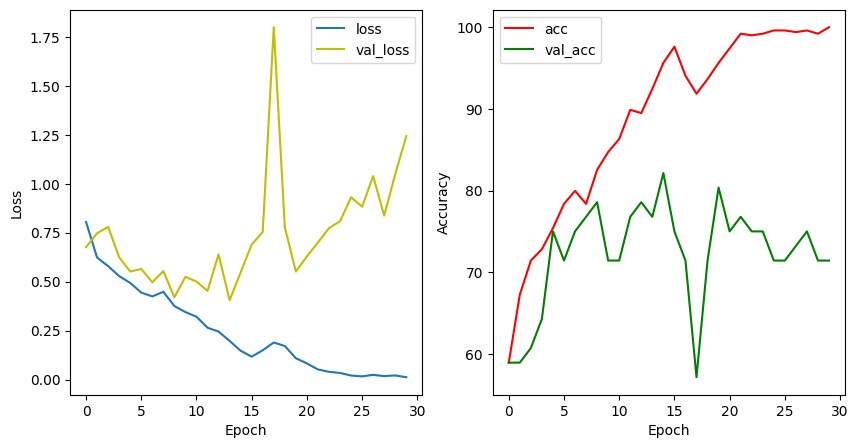

In [107]:
plt.figure()

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(np.arange(0, number_of_epochs), loss, label="loss")
ax[0].plot(np.arange(0, number_of_epochs), val_loss, color="y", label="val_loss")

ax[1].plot(np.arange(0, number_of_epochs), acc, color="r", label="acc")
ax[1].plot(np.arange(0, number_of_epochs), val_acc, color="g", label="val_acc")
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend(loc="best")
ax[1].legend(loc="best")

## Evaluate the model

Finally, we once again print a classification report for the test set; we see that adding a convolutional layer improves the classification results considerably.

In [108]:
from sklearn.metrics import classification_report

y_pred_cnn = model.predict(test_loader)
print(classification_report(y_test, y_pred_cnn))

100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

              precision    recall  f1-score   support

           0       0.64      0.71      0.67        79
           1       0.56      0.48      0.51        61

    accuracy                           0.61       140
   macro avg       0.60      0.59      0.59       140
weighted avg       0.60      0.61      0.60       140



## Using out-of-the-box CNNs with PyTorch

Instead of defining our own convolution neural network, we can also use one of the state-of-the-art convolutional neural networks that `PyTorch` provides. The `torchvision.models` package provides several pre-trained networks that we can use. An overview of the available models can be found [here](https://pytorch.org/vision/main/models.html#classification). Here, we will show you how to use the `resnet18` model. This model is a convolutional neural network that has 18 layers and is trained on the ImageNet data set. We will use this model to classify the images in the Cats and Dogs dataset.
 
By using a network with pre-trained weights we can reuse the convolutional kernels that have been derived from this large data set and adapt to our specific classification task. Using pre-trained weights and starting our training process from there is called **transfer learning**. An example of using a pre-trained network provided by `PyTorch` is given below. For `resnet18` we need to preprocess the images in a slightly different way. We will first provide the code to create the dataloaders that use that new preprocessing.

In [109]:
from torchvision.models import resnet18

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x if x.shape[0] == 3 else x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

train_dataset = CatsDogsDataset(X_train, y_train, transform=transform)
val_dataset = CatsDogsDataset(X_val, y_val, transform=transform)
test_dataset = CatsDogsDataset(X_test, y_test, transform=transform)
    
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Below we load the `resnet18` model and add a new final layer. The `resnet18` model is trained on the ImageNet dataset, which has 1000 classes. Therefore the default model has a 1000 classification outputs. The cats and dogs dataset only has two classes. Therefore, we need to replace the final layer with a new layer that has 2 classes. 

In [ ]:
model = resnet18()

# add a final layer for binary classification
model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 1),
            nn.Sigmoid()
) 
model = model.to(device)

We will now train the model for 10 epochs. 

In [111]:
number_of_epochs = 10
loss, val_loss, acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=number_of_epochs, device=device)

Epoch 1:
Training - Loss: 0.7460, Accuracy: 47.02%
Validation - Loss: 0.7317, Accuracy: 41.07%
Epoch 2:
Training - Loss: 0.7492, Accuracy: 47.02%
Validation - Loss: 0.7571, Accuracy: 41.07%
Epoch 3:
Training - Loss: 0.7481, Accuracy: 47.02%
Validation - Loss: 0.7760, Accuracy: 41.07%
Epoch 4:
Training - Loss: 0.7477, Accuracy: 47.02%
Validation - Loss: 0.7823, Accuracy: 41.07%
Epoch 5:
Training - Loss: 0.7447, Accuracy: 47.02%
Validation - Loss: 0.7825, Accuracy: 41.07%
Epoch 6:
Training - Loss: 0.7469, Accuracy: 47.02%
Validation - Loss: 0.7833, Accuracy: 41.07%
Epoch 7:
Training - Loss: 0.7436, Accuracy: 47.02%
Validation - Loss: 0.7830, Accuracy: 41.07%
Epoch 8:
Training - Loss: 0.7447, Accuracy: 47.02%
Validation - Loss: 0.7828, Accuracy: 41.07%
Epoch 9:
Training - Loss: 0.7488, Accuracy: 47.02%
Validation - Loss: 0.7852, Accuracy: 41.07%
Epoch 10:
Training - Loss: 0.7458, Accuracy: 47.02%
Validation - Loss: 0.7842, Accuracy: 41.07%


Also here we can plot the learning curves

<Figure size 640x480 with 0 Axes>

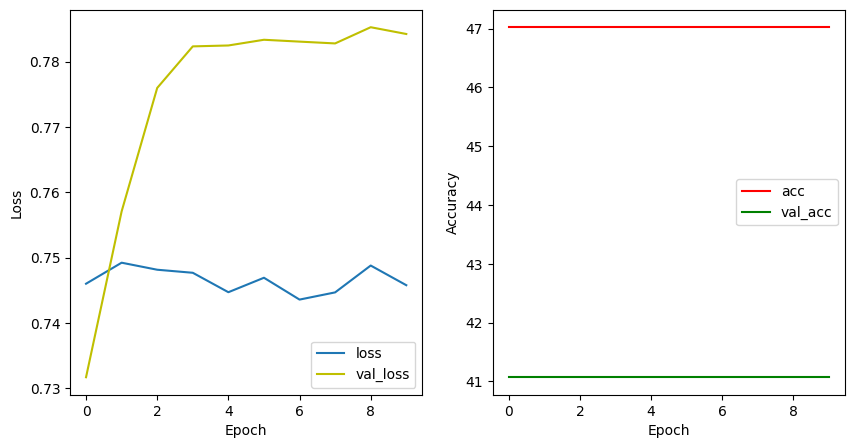

In [112]:
plt.figure()

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(np.arange(0, number_of_epochs), loss, label="loss")
ax[0].plot(np.arange(0, number_of_epochs), val_loss, color="y", label="val_loss")

ax[1].plot(np.arange(0, number_of_epochs), acc, color="r", label="acc")
ax[1].plot(np.arange(0, number_of_epochs), val_acc, color="g", label="val_acc")
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend(loc="best")
ax[1].legend(loc="best")

And finally, we can evaluate the model on the test set.

In [113]:
def predict(model, dataloader, device='cpu', show_progress=True):
        # Set model to evaluation mode
        model.eval()
        model.to(device)
    
        all_predictions = []
    
        # Disable gradients
        with torch.no_grad():
            # Setup progress bar if requested
            iterator = tqdm.tqdm(dataloader) if show_progress else dataloader
        
            for batch in iterator:
                # Handle different batch types
                if isinstance(batch, (tuple, list)):
                    x = batch[0]
                else:
                    x = batch
                
                # Move batch to device
                x = x.to(device)
            
                # Get predictions
                outputs = model(x)
            
                # Convert to predictions based on task
                if outputs.shape[-1] > 1:  # Multi-class
                    predictions = outputs.argmax(dim=-1)
                else:  # Binary or regression
                    predictions = (outputs > 0.5).float()
            
                # Move to CPU and collect
                all_predictions.append(predictions.cpu())
    
    # Concatenate all batches
        return torch.cat(all_predictions).numpy()

In [114]:
from sklearn.metrics import classification_report

y_pred_cnn = predict(model, test_loader)
print(classification_report(y_test, y_pred_cnn))

100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.44      1.00      0.61        61

    accuracy                           0.44       140
   macro avg       0.22      0.50      0.30       140
weighted avg       0.19      0.44      0.26       140




/Users/timdejong/.pyenv/versions/ai_course/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/timdejong/.pyenv/versions/ai_course/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/timdejong/.pyenv/versions/ai_course/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

# Conclusion

In this notebook, we have shown how to use convolutional neural networks to classify images in the Cats and Dogs dataset. We have shown how to define a convolutional neural network from scratch using `PyTorch`. We have also shown how to use a pre-trained convolutional neural network from `PyTorch` to classify images. We have seen that using convolutional neural networks can improve the classification performance compared to using handcrafted features. Another huge advantage of using convolutional neural networks is that they can be trained in batches, which makes it possible to train them on large datasets.